# features_processed 可視化ノートブック

`data/02_PreprocessedData/Clea/features_processed_Clea.csv` を読み込み、ゾーン別・期間指定で主要指標を可視化します。

可視化内容:
- 予報・実績: Outdoor Temp., Solar Radiation, Indoor Temp.
- 制御: A/C Set Temperature, A/C Mode, A/C Fan Speed
- 運転: A/C ON/OFF（台数、0=OFF,1=ONの合計）
- 電力: adjusted_power



In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display

# 日本語フォント
plt.rcParams['font.family'] = ['Hiragino Sans', 'IPAexGothic', 'Noto Sans CJK JP', 'Arial Unicode MS', 'TakaoGothic']
plt.rcParams['axes.unicode_minus'] = False

# プロジェクトルート
cwd = Path.cwd()
project_root = cwd.parent if cwd.name == 'notebooks' else cwd
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

FEATURES_CSV = project_root / 'data/02_PreprocessedData/Clea/features_processed_Clea.csv'
print('Project root:', project_root)
print('Features:', FEATURES_CSV)



Project root: /Users/tomokiinoue/Desktop/workspace/AIrux8_opti_logic
Features: /Users/tomokiinoue/Desktop/workspace/AIrux8_opti_logic/data/02_PreprocessedData/Clea/features_processed_Clea.csv


In [2]:
# 読み込み
assert FEATURES_CSV.exists(), f'ファイルが見つかりません: {FEATURES_CSV}'
df = pd.read_csv(FEATURES_CSV)

# datetime整形
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'])
else:
    raise ValueError('Datetime列が見つかりません')

# 並び替え（zone昇順, Datetime降順）
df.sort_values(['zone','Datetime'], ascending=[True, False], inplace=True)

zones = sorted(df['zone'].dropna().unique().tolist())
print('Zones:', zones)
print('Shape:', df.shape, df['Datetime'].min(), '->', df['Datetime'].max())



Zones: ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Break Room', 'Meeting Room']
Shape: (64723, 19) 2024-06-30 15:00:00 -> 2025-09-28 01:00:00


___
**可視化**

In [3]:
# 1) カテゴリーマッピングの読込（未定義なら追加）
import json

def load_category_mappings():
    with open(project_root / 'config/category_mapping.json', 'r', encoding='utf-8') as f:
        m = json.load(f)
    inv = {k: {v2: k2 for k2, v2 in v.items()} for k, v in m.items()}
    return m, inv

CATEGORY_MAP, CATEGORY_INV = load_category_mappings()

# 2) ON/OFFスタイル描画ヘルパー（未定義なら追加）
def plot_onoff_step(ax, x, y, on_mask, color, label, where='mid'):
    # ON: 実線/太線
    ax.step(x[on_mask], y[on_mask], where=where, color=color, lw=2.2, linestyle='solid', label=label)
    # OFF: 点線/細線
    ax.step(x[~on_mask], y[~on_mask], where=where, color=color, lw=1.2, linestyle='--', label=f'{label} (OFF)')

def plot_onoff_line(ax, x, y, on_mask, color, label):
    ax.plot(x[on_mask], y[on_mask], color=color, lw=2.2, linestyle='solid', label=label)
    ax.plot(x[~on_mask], y[~on_mask], color=color, lw=1.2, linestyle='--', label=f'{label} (OFF)')

In [4]:
from matplotlib.patches import Patch

def plot_zone_features(df: pd.DataFrame, zone: str, start: str = '', end: str = ''):
    # 抽出・整列
    zdf = df[df['zone'] == zone].copy()
    if start:
        zdf = zdf[zdf['Datetime'] >= pd.to_datetime(start)]
    if end:
        zdf = zdf[zdf['Datetime'] <= pd.to_datetime(end)]
    if zdf.empty:
        print('⚠️ データがありません')
        return
    zdf = zdf.sort_values('Datetime').reset_index(drop=True)

    x = zdf['Datetime']
    x_min, x_max = x.min(), x.max()

    # ON/OFF判定（ON = Units>0 AND Status>0）
    units = zdf.get('A/C ON/OFF', pd.Series(0, index=zdf.index)).fillna(0)
    status = zdf.get('A/C Status', pd.Series(0, index=zdf.index)).fillna(0)
    on_mask = (units > 0) & (status > 0)
    off_mask = ~on_mask

    # サンプリング間隔（bar 幅に使用）
    dt = zdf['Datetime'].diff().median()
    if pd.isna(dt) or dt <= pd.Timedelta(0):
        dt = pd.Timedelta(hours=1)
    width_days = dt / np.timedelta64(1, 'D')

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

    def shade_off(ax):
        if off_mask.any():
            for t, is_off in zip(x, off_mask):
                if is_off:
                    ax.axvspan(t, t + dt, color='whitesmoke', alpha=1, zorder=0)

    # === 上段: y1=Power(bar), y2=Temps(line/step) ===
    ax = axes[0]
    shade_off(ax)
    handles = []; labels = []

    # Power（棒・左端基準）凡例は箱、handleheight=0.5
    if 'adjusted_power' in zdf.columns:
        y_pow = zdf['adjusted_power'].astype(float)
        ax.bar(x, y_pow, width=width_days, align='edge', color='gold', alpha=0.25, linewidth=0.5, label='Power', zorder=2, edgecolor="dimgrey")
        h_pow = Patch(facecolor='gold', edgecolor='none', alpha=0.25, label='Power')
        handles.append(h_pow); labels.append('Power')
        ax.set_ylim(0, np.nanmax(y_pow) * 1.1 if np.isfinite(np.nanmax(y_pow)) else 1.0)

    # Temps（第二軸）
    ax2 = ax.twinx()
    if 'Outdoor Temp.' in zdf.columns:
        y_out = zdf['Outdoor Temp.'].astype(float)
        h_out, = ax2.plot(x, y_out, color='slategrey', lw=1.5, alpha=0.9, label='Outdoor Temp', zorder=3, ls='dashed')
        handles.append(h_out); labels.append('Outdoor Temp')
    if 'A/C Set Temperature' in zdf.columns:
        y_set = zdf['A/C Set Temperature'].astype(float).where(on_mask, np.nan)
        h_set = ax2.step(x, y_set, where='post', color='dodgerblue', lw=3.0, label='Set Temp', zorder=3, linestyle='dotted')[0]
        handles.append(h_set); labels.append('Set Temp')
    if 'Indoor Temp.' in zdf.columns:
        y_ind = zdf['Indoor Temp.'].astype(float)
        h_ind, = ax2.plot(x, y_ind, color='dodgerblue', lw=1.5, alpha=0.9, label='Indoor Temp', zorder=3, ls='solid')
        handles.append(h_ind); labels.append('Indoor Temp')

    temps = []
    for col in ['A/C Set Temperature', 'Indoor Temp.', 'Outdoor Temp.']:
        if col in zdf.columns:
            vals = zdf[col].astype(float)
            if col == 'A/C Set Temperature':
                vals = vals.where(on_mask, np.nan)
            temps += list(vals.dropna().values)
    if temps:
        ax2.set_ylim(min(temps) - 1.0, max(temps) + 1.0)
        ax2.set_ylim(0,40)

    ax.set_title(f'{zone} - Power & Temperatures', loc='left')
    ax.set_ylabel('Power [kWh]'); ax2.set_ylabel('Temp [°C]')
    if handles:
        ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.1, 0.5), handleheight=0.5, frameon=True)
    ax.set_xlim(x_min, x_max + dt)

    # === 下段: y1=Units(bar), y2=Mode, y3=Fan(右オフセット), yL=ON/OFF(左オフセット) ===
    ax = axes[1]
    shade_off(ax)
    handles = []; labels = []

    # Units（棒、ONのみ・左端基準）凡例は箱
    if 'A/C ON/OFF' in zdf.columns:
        y_units = zdf['A/C ON/OFF'].fillna(0).astype(float)
        ax.bar(x[on_mask], y_units[on_mask], width=width_days, align='edge', color='dodgerblue', alpha=0.25, linewidth=0.5, label='Units', zorder=2, edgecolor="dimgrey")
        h_units = Patch(facecolor='dodgerblue', edgecolor='none', alpha=0.25, label='Units')
        handles.append(h_units); labels.append('Units')
        ymax = int(np.nanmax(y_units)) if np.isfinite(np.nanmax(y_units)) else 1
        ax.set_ylim(0, max(ymax, 1) + 0.5)

    # 右（Mode）
    ax_mode = ax.twinx()
    # 右オフセット（Fan）
    ax_fan = ax.twinx()
    ax_fan.spines['right'].set_position(('axes', 1.12))

    # グリッドは補助軸で無効化
    for aux in [ax_mode, ax_fan]:
        aux.grid(False)
        aux.set_facecolor('none')

    # Mode（ONのみ、step-post）
    if 'A/C Mode' in zdf.columns:
        y_mode = zdf['A/C Mode'].fillna(0).astype(int).where(on_mask, np.nan)
        h_mode = ax_mode.step(x, y_mode, where='post', color='tab:gray', lw=2.0, label='Mode', zorder=3)[0]
        handles.append(h_mode); labels.append('Mode')
        # 目盛は全候補を表示（数値+名称）
        ticks_mode, labels_mode = [], []
        if 'A/C Mode' in CATEGORY_INV:
            inv = CATEGORY_INV['A/C Mode']  # {code: name}
            for code in sorted(inv.keys()):
                ticks_mode.append(code)
                labels_mode.append(f"{code} {inv[code]}")
        else:
            vals = sorted(set(zdf['A/C Mode'].dropna().astype(int).tolist()))
            ticks_mode = vals; labels_mode = [str(v) for v in vals]
        if ticks_mode:
            ax_mode.set_yticks(ticks_mode)
            ax_mode.set_yticklabels(labels_mode)
            ax_mode.set_ylim(min(ticks_mode) - 0.5, max(ticks_mode) + 0.5)
            ax_mode.set_ylabel('Mode', rotation=90)

    # Fan（ONのみ、step-post）
    if 'A/C Fan Speed' in zdf.columns:
        y_fan = zdf['A/C Fan Speed'].fillna(0).astype(int).where(on_mask, np.nan)
        h_fan = ax_fan.step(x, y_fan, where='post', color='tab:green', lw=2.0, label='Fan', zorder=3)[0]
        handles.append(h_fan); labels.append('Fan')
        ticks_fan, labels_fan = [], []
        if 'A/C Fan Speed' in CATEGORY_INV:
            inv = CATEGORY_INV['A/C Fan Speed']
            for code in sorted(inv.keys()):
                ticks_fan.append(code)
                labels_fan.append(f"{code} {inv[code]}")
        else:
            vals = sorted(set(zdf['A/C Fan Speed'].dropna().astype(int).tolist()))
            ticks_fan = vals; labels_fan = [str(v) for v in vals]
        if ticks_fan:
            ax_fan.set_yticks(ticks_fan)
            ax_fan.set_yticklabels(labels_fan)
            ax_fan.set_ylim(min(ticks_fan) - 0.5, max(ticks_fan) + 0.5)
            ax_fan.set_ylabel('Fan', rotation=90)


    ax.set_title(f'{zone} - Units & Mode/Fan/ON-OFF', loc='left')
    ax.set_ylabel('Units')
    if handles:
        ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.25, 0.5), handleheight=0.5, frameon=True)
    ax.set_xlim(x_min, x_max + dt)

    # 体裁
    for a in axes:
        a.grid(True, alpha=0.2)
    # x軸は mm/dd + 曜日(%a)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n(%a)'))
    axes[-1].xaxis.set_major_locator(mdates.DayLocator())
    fig.suptitle(f'Features Visualization: {zone}', fontsize=13, ha='left', x=0.01)
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_all_zones(features_csv_path: str, start: str = '', end: str = ''):
    """
    指定CSVを読み込み、全ゾーンを順番に可視化する。

    Args:
        features_csv_path: features_processed のCSVパス
        start: フィルタ開始日(YYYY-MM-DD) 任意
        end: フィルタ終了日(YYYY-MM-DD) 任意
    """
    path = Path(features_csv_path)
    if not path.exists():
        print(f'❌ ファイルが見つかりません: {path}')
        return
    _df = pd.read_csv(path)
    if 'Datetime' not in _df.columns or 'zone' not in _df.columns:
        print('❌ 必須列(Datetime, zone)が見つかりません')
        return
    _df['Datetime'] = pd.to_datetime(_df['Datetime'])
    _df.sort_values(['zone','Datetime'], ascending=[True, False], inplace=True)
    _zones = sorted(_df['zone'].dropna().unique().tolist())
    print(f'✅ 読み込み: shape={_df.shape}, zones={_zones}')
    for _z in _zones:
        print(f'--- Plot: {_z} ---')
        plot_zone_features(_df, _z, start, end)

✅ 読み込み: shape=(64723, 19), zones=['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Break Room', 'Meeting Room']
--- Plot: Area 1 ---


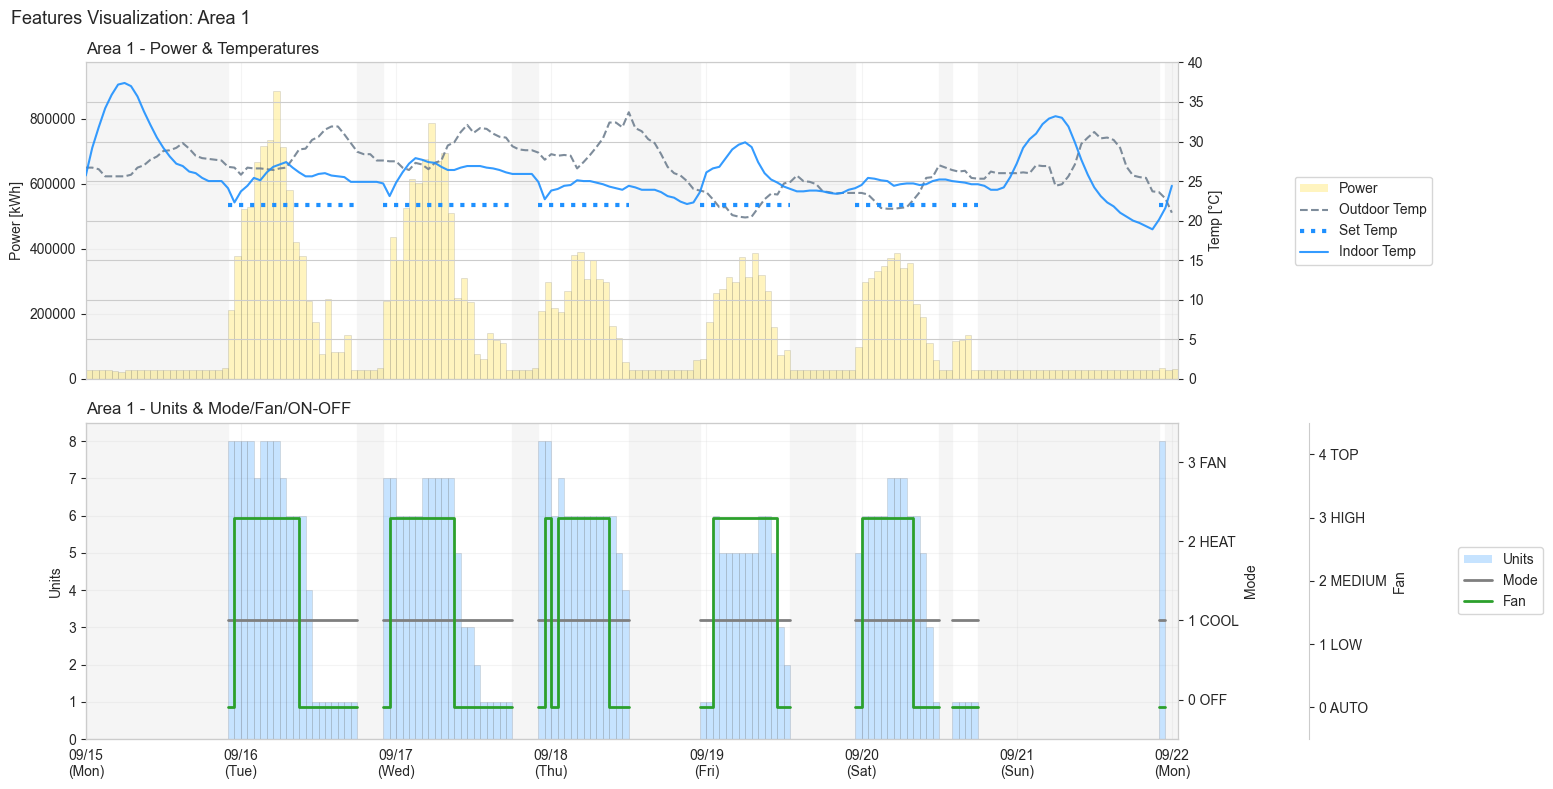

--- Plot: Area 2 ---


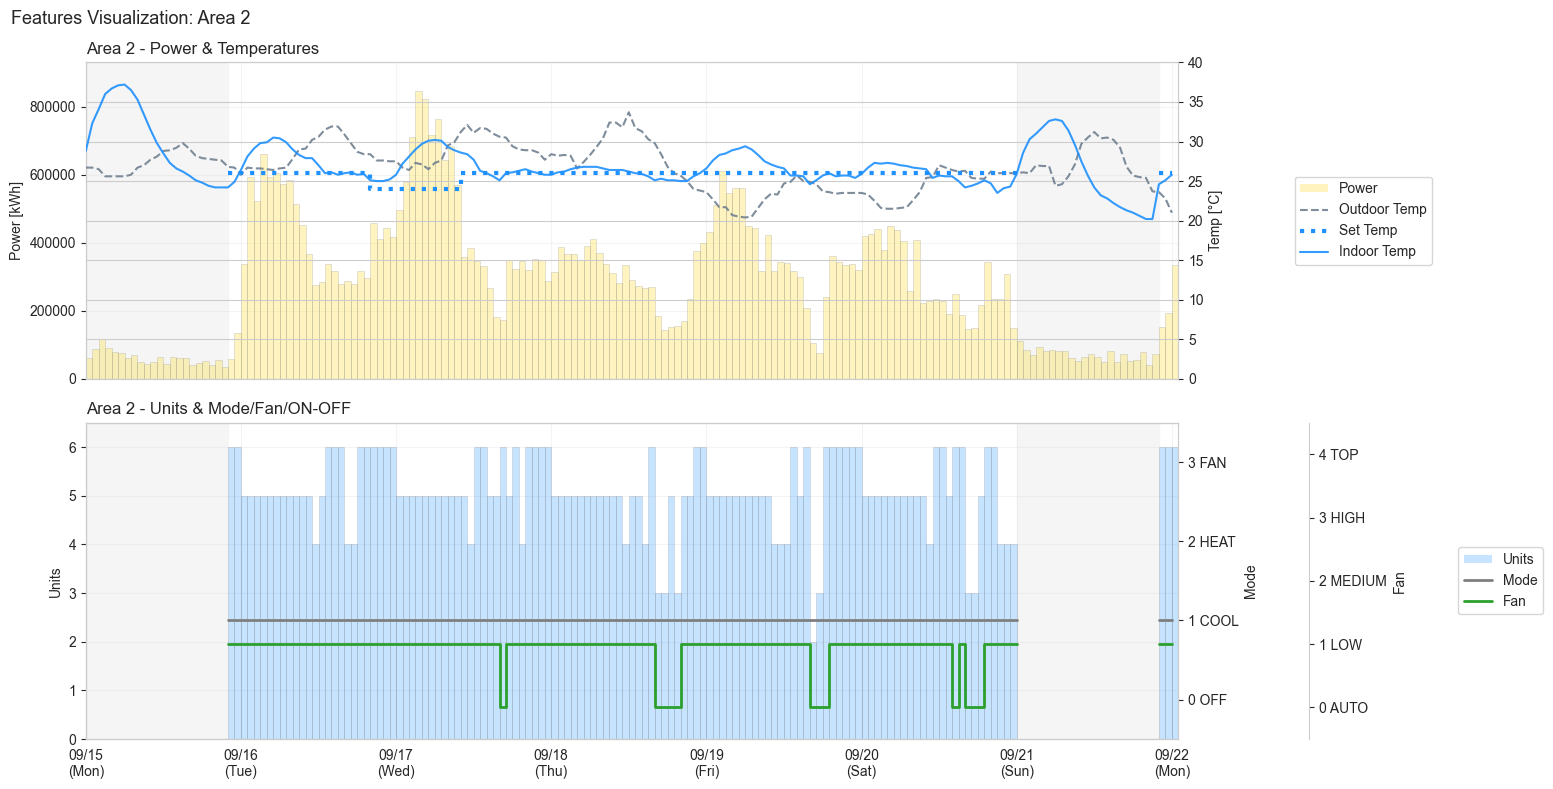

--- Plot: Area 3 ---


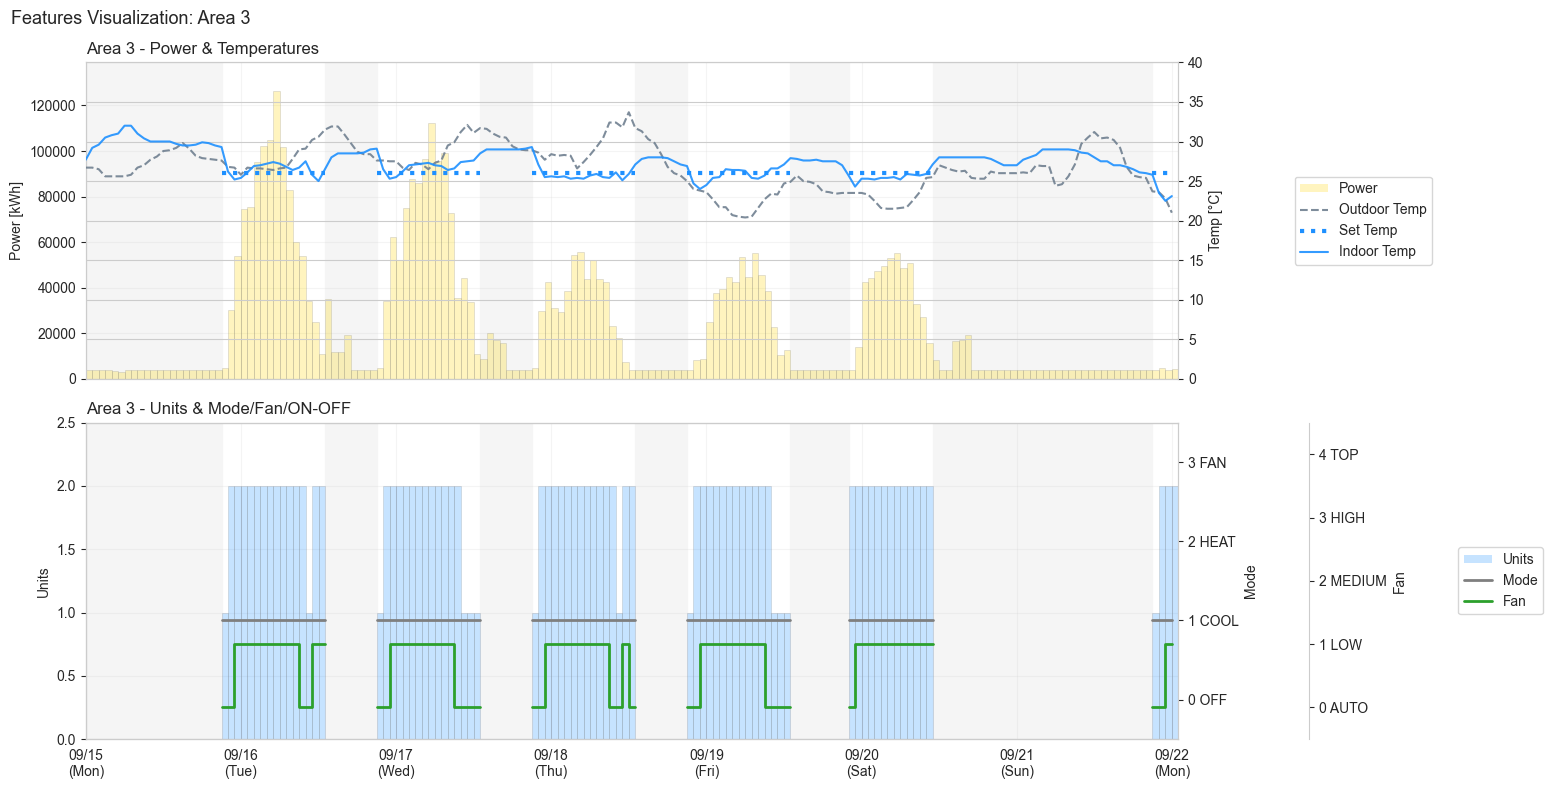

--- Plot: Area 4 ---


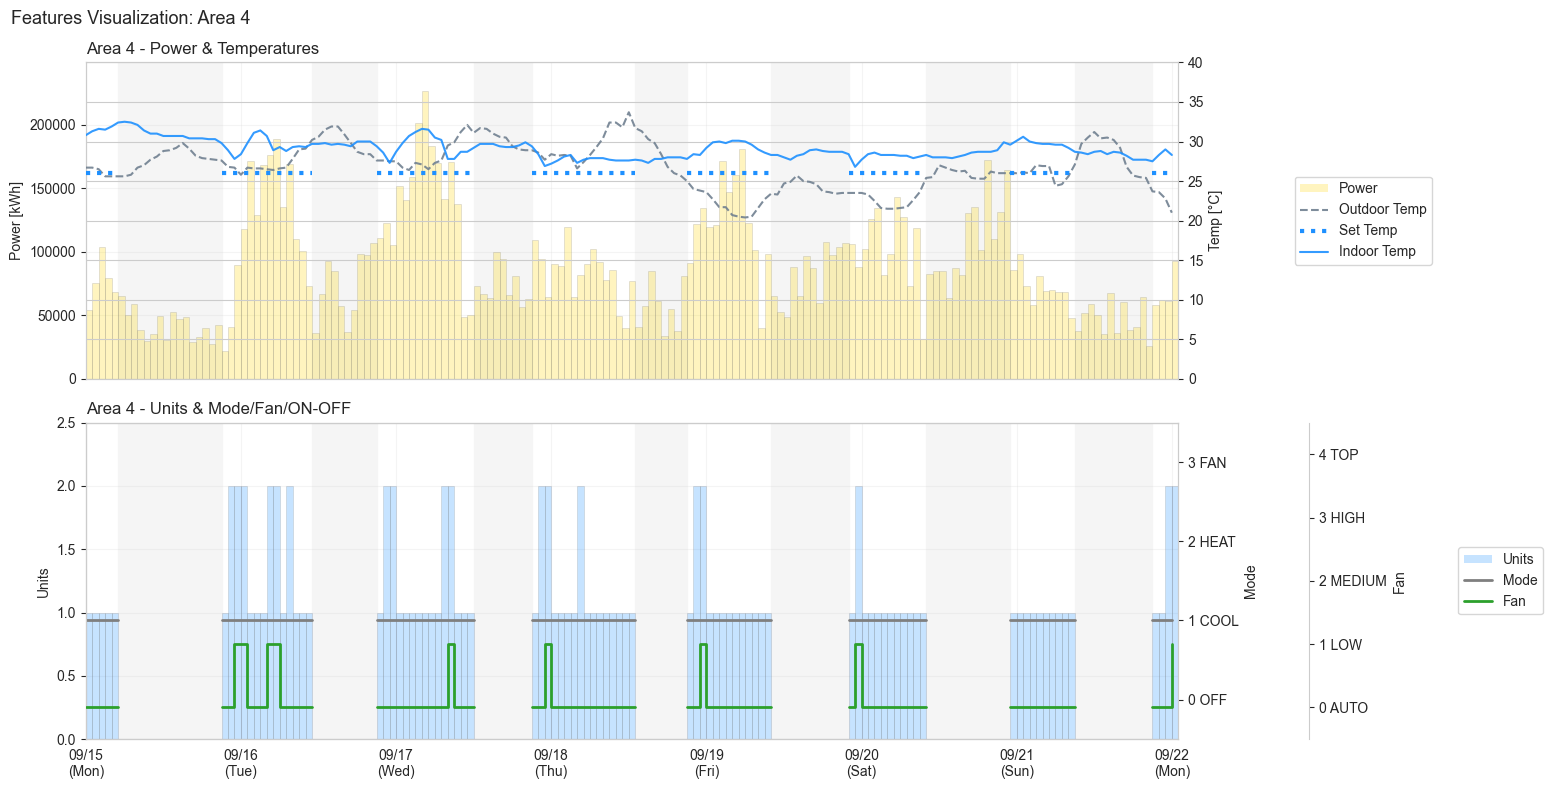

--- Plot: Break Room ---


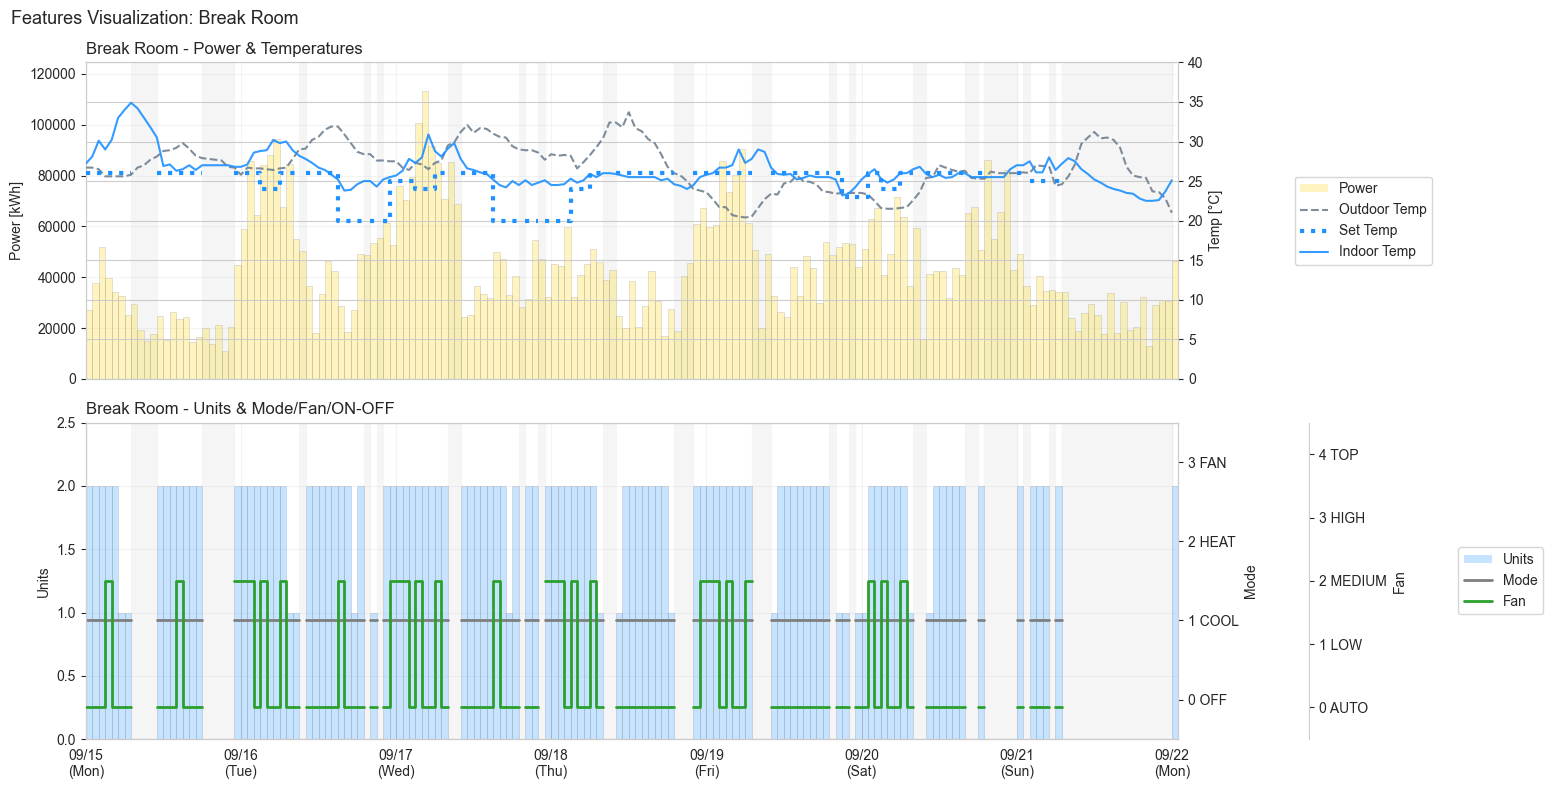

--- Plot: Meeting Room ---


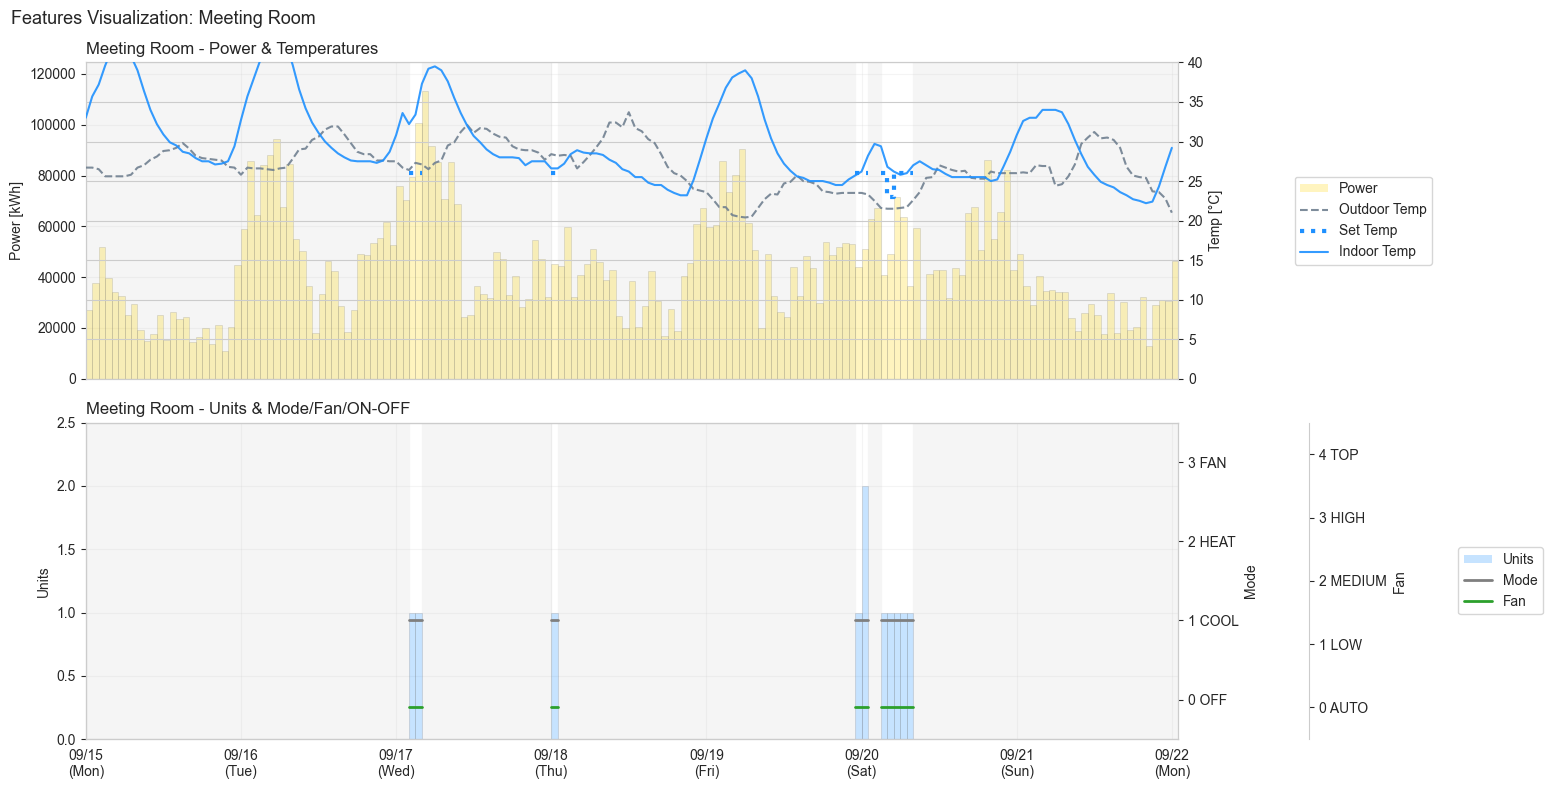

In [6]:
# 変数で指定して一括可視化（入力ボックスは使用しない）
FEATURES_CSV_PATH = str(project_root / 'data/02_PreprocessedData/Clea/features_processed_Clea.csv')
START = '2025-9-15'  # 例: '2025-01-01'
END = '2025-9-22'    # 例: '2025-01-31'
visualize_all_zones(FEATURES_CSV_PATH, start=START, end=END)

___
計画

In [7]:
from matplotlib.patches import Patch

def infer_plan_zones(columns):
    zones = []
    for c in columns:
        if c.endswith('_set_temp'):
            zones.append(c[:-9])  # remove suffix
    return sorted(list(set(zones)))


def plot_zone_plan_styled(plan_df: pd.DataFrame, zone: str, start: str = '', end: str = ''):
    # 必須列確認
    need_cols = [
        'datetime', 'forecast_outdoor_temp',
        f'{zone}_set_temp', f'{zone}_mode', f'{zone}_fan_speed',
        f'{zone}_numb_units_on', f'{zone}_ac_on_off', f'{zone}_power'
    ]
    missing = [c for c in need_cols if c not in plan_df.columns]
    if missing:
        print(f"❌ 必須列が不足: {missing}")
        return

    zdf = plan_df.copy()
    if start:
        zdf = zdf[zdf['datetime'] >= pd.to_datetime(start)]
    if end:
        zdf = zdf[zdf['datetime'] <= pd.to_datetime(end)]
    if zdf.empty:
        print('⚠️ フィルタ後データが空です')
        return
    zdf = zdf.sort_values('datetime').reset_index(drop=True)

    x = zdf['datetime']
    x_min, x_max = x.min(), x.max()

    # ON/OFF 判定（Units>0 AND ac_on_off>0/'ON'）
    units = pd.to_numeric(zdf[f'{zone}_numb_units_on'], errors='coerce').fillna(0.0)
    ac_raw = zdf[f'{zone}_ac_on_off']
    status_num = pd.to_numeric(ac_raw, errors='coerce')
    status_num = status_num.where(status_num.notna(), ac_raw.astype(str).str.upper().map({'ON': 1.0, 'OFF': 0.0}))
    status = status_num.fillna(0.0)
    on_mask = (units > 0) & (status > 0)
    off_mask = ~on_mask

    # サンプリング間隔（棒幅に使用）
    dt = zdf['datetime'].diff().median()
    if pd.isna(dt) or dt <= pd.Timedelta(0):
        dt = pd.Timedelta(hours=1)
    width_days = dt / np.timedelta64(1, 'D')

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

    def shade_off(ax):
        if off_mask.any():
            for t, is_off in zip(x, off_mask):
                if is_off:
                    ax.axvspan(t, t + dt, color='whitesmoke', alpha=1, zorder=0)

    # 上段: Power(bar) + Temps(Outdoor/Set/Indoor)
    ax = axes[0]
    shade_off(ax)
    handles = []; labels = []

    y_pow = pd.to_numeric(zdf[f'{zone}_power'], errors='coerce')
    ax.bar(x, y_pow, width=width_days, align='edge', color='gold', alpha=0.25, linewidth=0.5, edgecolor='dimgrey', label='Power', zorder=2)
    handles.append(Patch(facecolor='gold', edgecolor='none', alpha=0.25, label='Power')); labels.append('Power')
    if np.isfinite(np.nanmax(y_pow)):
        ax.set_ylim(0, np.nanmax(y_pow) * 1.1)

    ax2 = ax.twinx()
    y_out = pd.to_numeric(zdf['forecast_outdoor_temp'], errors='coerce')
    h_out, = ax2.plot(x, y_out, color='slategrey', lw=1.5, alpha=0.9, label='Outdoor Temp', zorder=3, ls='dashed')
    handles.append(h_out); labels.append('Outdoor Temp')

    y_set = pd.to_numeric(zdf[f'{zone}_set_temp'], errors='coerce').where(on_mask, np.nan)
    h_set = ax2.step(x, y_set, where='post', color='dodgerblue', lw=3.0, label='Set Temp', zorder=3, linestyle='dotted')[0]
    handles.append(h_set); labels.append('Set Temp')

    if f'{zone}_indoor_temp' in zdf.columns:
        y_ind = pd.to_numeric(zdf[f'{zone}_indoor_temp'], errors='coerce')
        h_ind, = ax2.plot(x, y_ind, color='dodgerblue', lw=1.5, alpha=0.9, label='Indoor Temp', zorder=3, ls='solid')
        handles.append(h_ind); labels.append('Indoor Temp')

    temps = []
    for s in [y_out, y_set, zdf.get(f'{zone}_indoor_temp', pd.Series(dtype=float))]:
        try:
            vals = pd.to_numeric(s, errors='coerce')
            temps += list(vals.dropna().values)
        except Exception:
            pass
    if temps:
        ax2.set_ylim(min(temps) - 1.0, max(temps) + 1.0)

    ax.set_title(f'{zone} - Power & Temperatures', loc='left')
    ax.set_ylabel('Power [kWh]'); ax2.set_ylabel('Temp [°C]')
    if handles:
        ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.1, 0.5), handleheight=0.5, frameon=True)
    ax.set_xlim(x_min, x_max + dt)

    # 下段: Units(bar) + Mode(step) + Fan(step)
    ax = axes[1]
    shade_off(ax)
    handles = []; labels = []

    ax.bar(x[on_mask], units[on_mask], width=width_days, align='edge', color='dodgerblue', alpha=0.25, linewidth=0.5, edgecolor='dimgrey', label='Units', zorder=2)
    handles.append(Patch(facecolor='dodgerblue', edgecolor='none', alpha=0.25, label='Units')); labels.append('Units')
    if np.isfinite(np.nanmax(units)):
        ax.set_ylim(0, max(int(np.nanmax(units)), 1) + 0.5)

    ax_mode = ax.twinx()
    ax_fan = ax.twinx(); ax_fan.spines['right'].set_position(('axes', 1.12))
    for aux in [ax_mode, ax_fan]:
        aux.grid(False); aux.set_facecolor('none')

    # Mode: to float + NaN 安全化
    mode_raw = zdf[f'{zone}_mode']
    mode_num = pd.to_numeric(mode_raw, errors='coerce')
    if mode_num.isna().all():
        codes = pd.Categorical(mode_raw).codes
        mode_num = pd.Series(codes, index=zdf.index).replace(-1, np.nan)
    y_mode = mode_num.where(on_mask, np.nan).astype(float)
    h_mode = ax_mode.step(x, y_mode, where='post', color='tab:gray', lw=2.0, label='Mode', zorder=3)[0]
    handles.append(h_mode); labels.append('Mode')

    ticks_mode, labels_mode = [], []
    if 'A/C Mode' in CATEGORY_INV:
        inv = CATEGORY_INV['A/C Mode']
        for code in sorted(inv.keys()):
            ticks_mode.append(code); labels_mode.append(f"{code} {inv[code]}")
    else:
        vals = sorted(set(pd.to_numeric(mode_raw, errors='coerce').dropna().astype(int).tolist()))
        ticks_mode = vals; labels_mode = [str(v) for v in vals]
    if ticks_mode:
        ax_mode.set_yticks(ticks_mode); ax_mode.set_yticklabels(labels_mode)
        ax_mode.set_ylim(min(ticks_mode) - 0.5, max(ticks_mode) + 0.5)
        ax_mode.set_ylabel('Mode', rotation=90)

    # Fan
    fan_raw = zdf[f'{zone}_fan_speed']
    fan_num = pd.to_numeric(fan_raw, errors='coerce')
    if fan_num.isna().all():
        codes = pd.Categorical(fan_raw).codes
        fan_num = pd.Series(codes, index=zdf.index).replace(-1, np.nan)
    y_fan = fan_num.where(on_mask, np.nan).astype(float)
    h_fan = ax_fan.step(x, y_fan, where='post', color='tab:green', lw=2.0, label='Fan', zorder=3)[0]
    handles.append(h_fan); labels.append('Fan')

    ticks_fan, labels_fan = [], []
    if 'A/C Fan Speed' in CATEGORY_INV:
        inv = CATEGORY_INV['A/C Fan Speed']
        for code in sorted(inv.keys()):
            ticks_fan.append(code); labels_fan.append(f"{code} {inv[code]}")
    else:
        vals = sorted(set(pd.to_numeric(fan_raw, errors='coerce').dropna().astype(int).tolist()))
        ticks_fan = vals; labels_fan = [str(v) for v in vals]
    if ticks_fan:
        ax_fan.set_yticks(ticks_fan); ax_fan.set_yticklabels(labels_fan)
        ax_fan.set_ylim(min(ticks_fan) - 0.5, max(ticks_fan) + 0.5)
        ax_fan.set_ylabel('Fan', rotation=90)

    ax.set_title(f'{zone} - Units & Mode/Fan', loc='left')
    ax.set_ylabel('Units')
    if handles:
        ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.25, 0.5), handleheight=0.5, frameon=True)
    ax.set_xlim(x_min, x_max + dt)

    # 体裁
    for a in axes:
        a.grid(True, alpha=0.2)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n(%a)'))
    axes[-1].xaxis.set_major_locator(mdates.DayLocator())
    fig.suptitle(f'Plan Visualization: {zone}', fontsize=13, ha='left', x=0.01)
    plt.tight_layout()
    plt.show()


✅ 計画読込: shape=(144, 75), zones=['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Break Room', 'Meeting Room']
--- Plan Plot: Area 1 ---


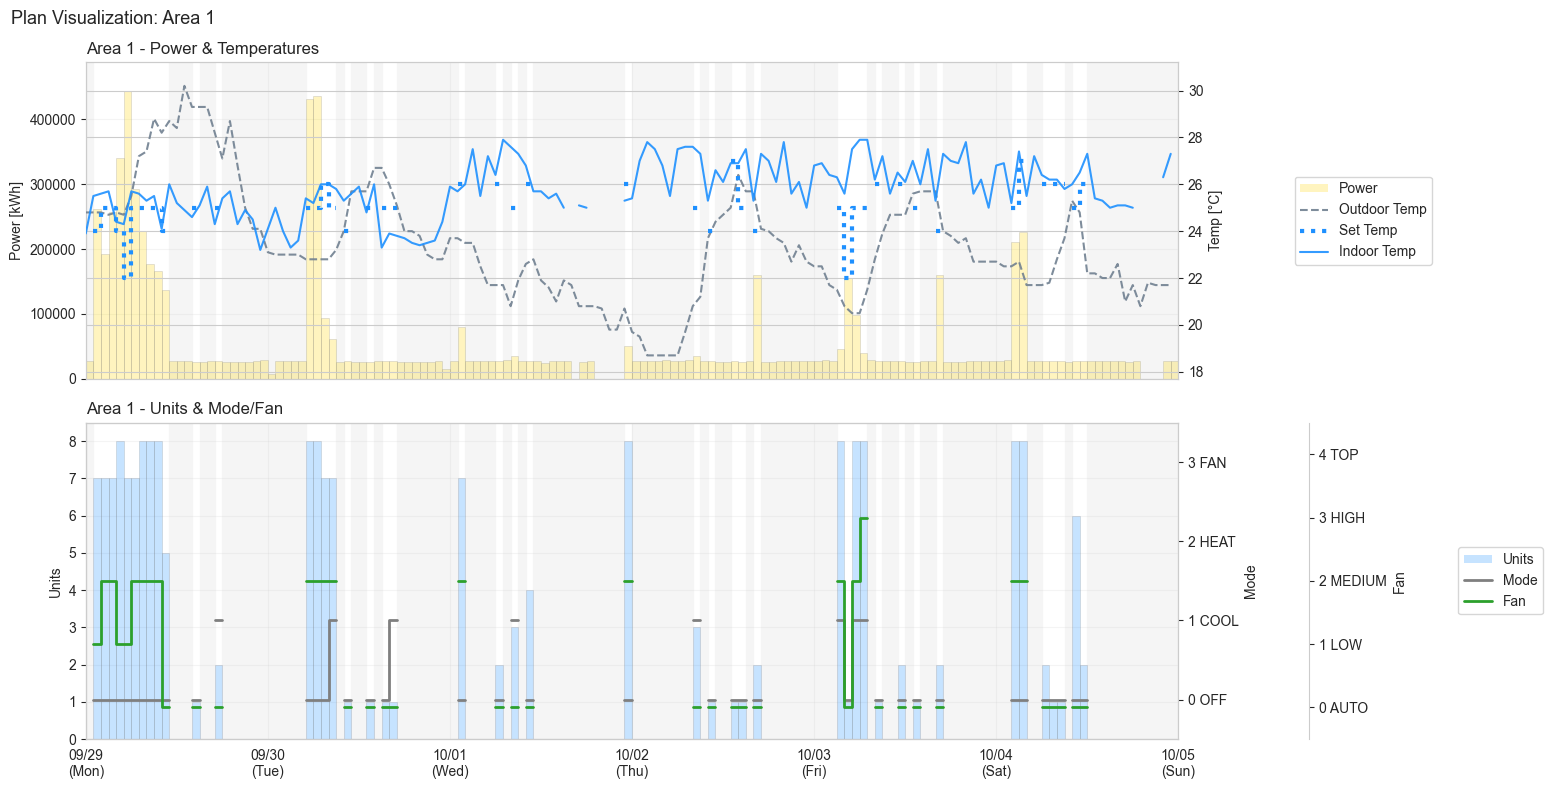

--- Plan Plot: Area 2 ---


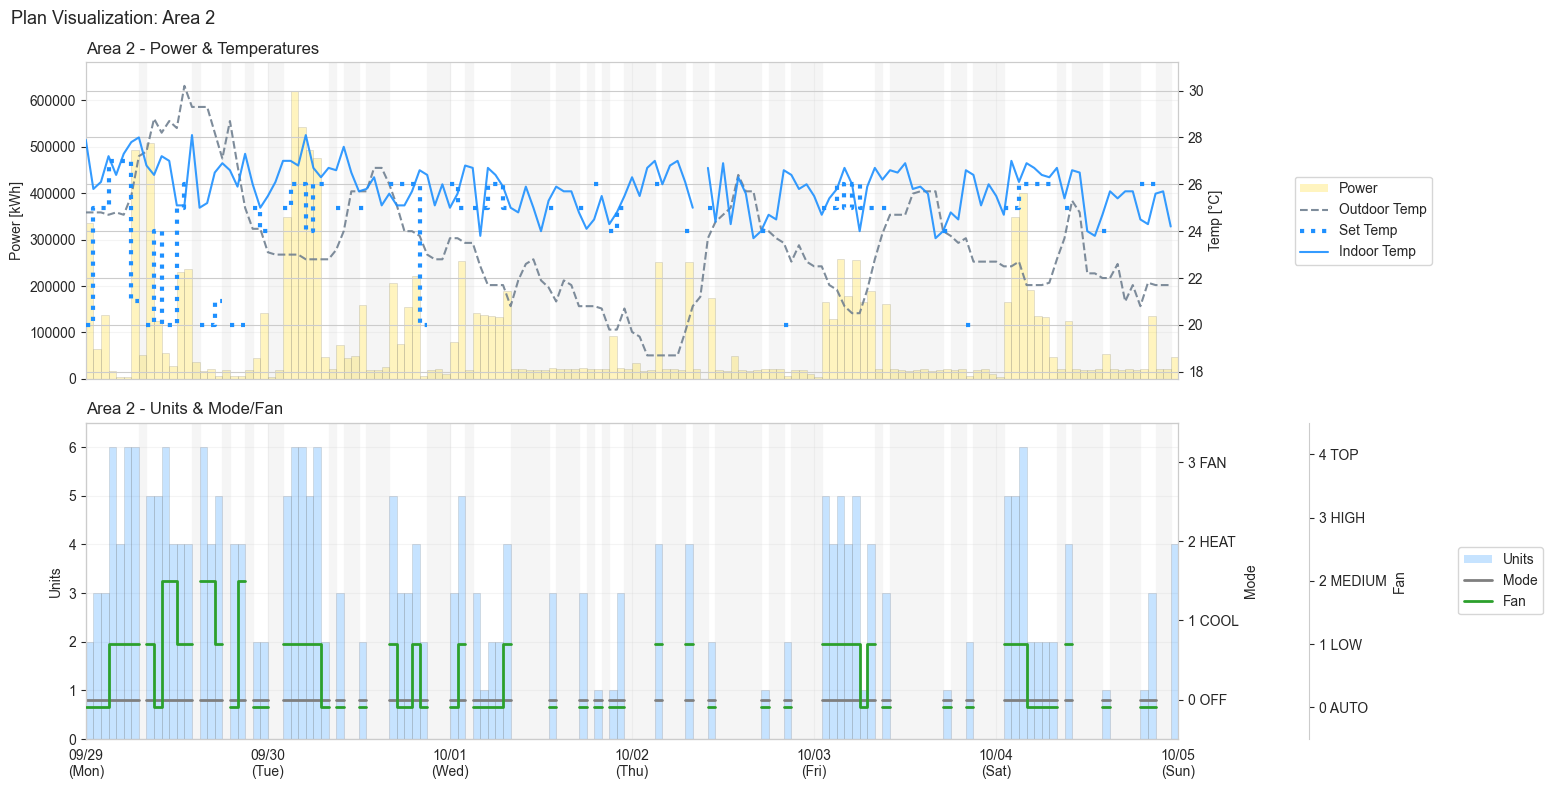

--- Plan Plot: Area 3 ---


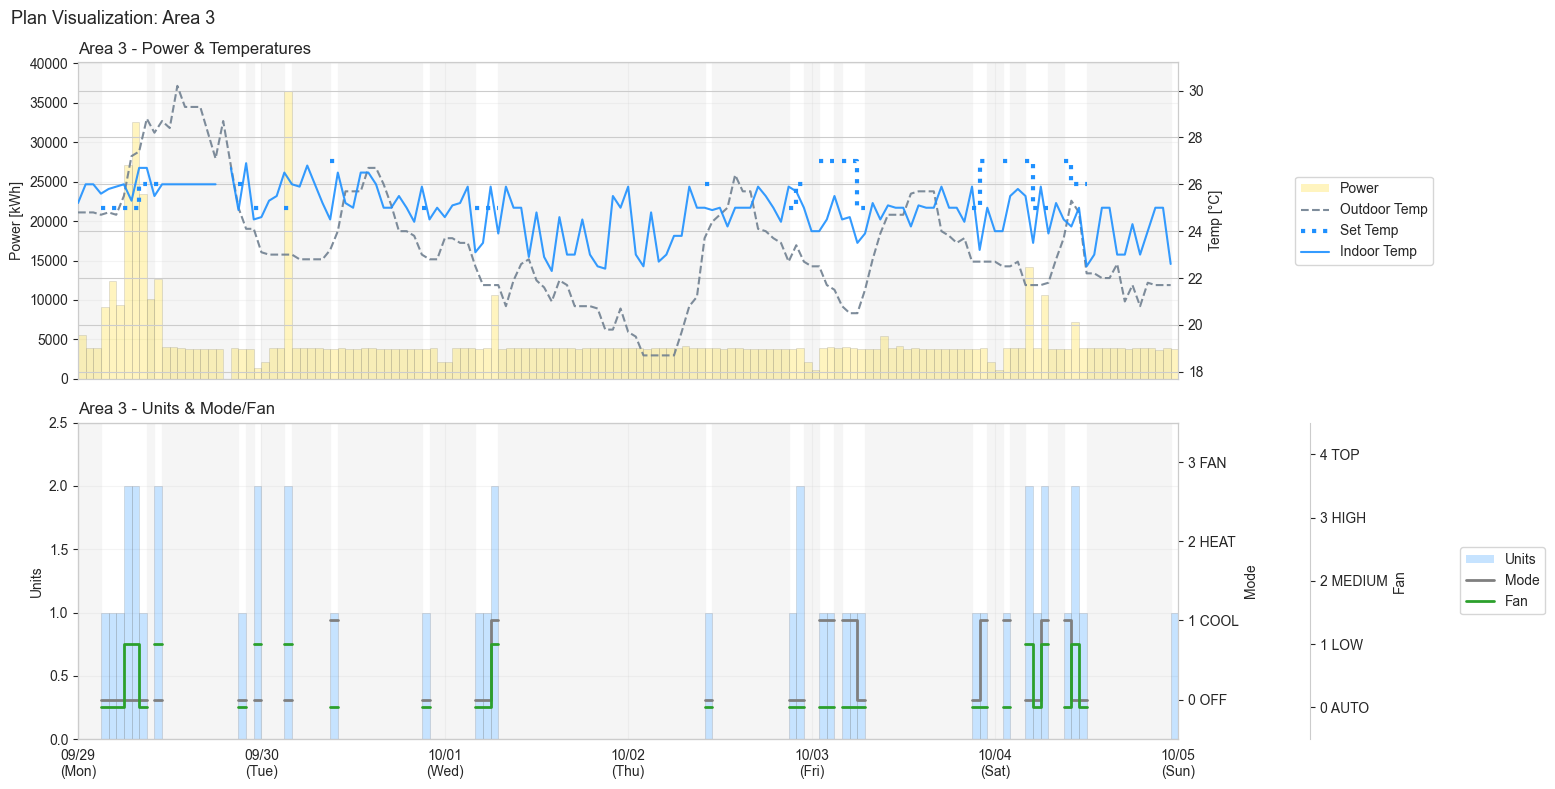

--- Plan Plot: Area 4 ---


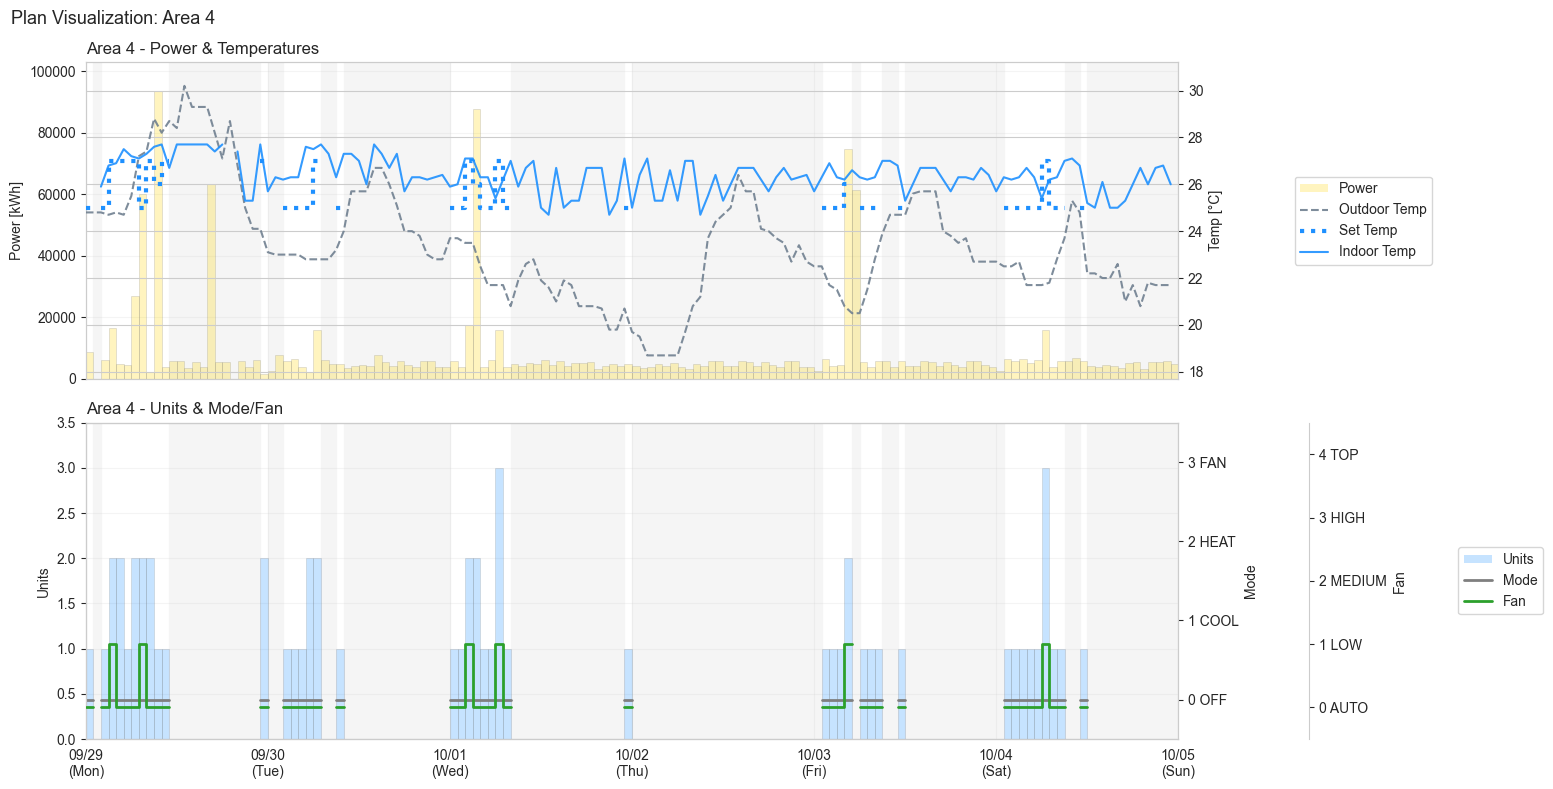

--- Plan Plot: Break Room ---


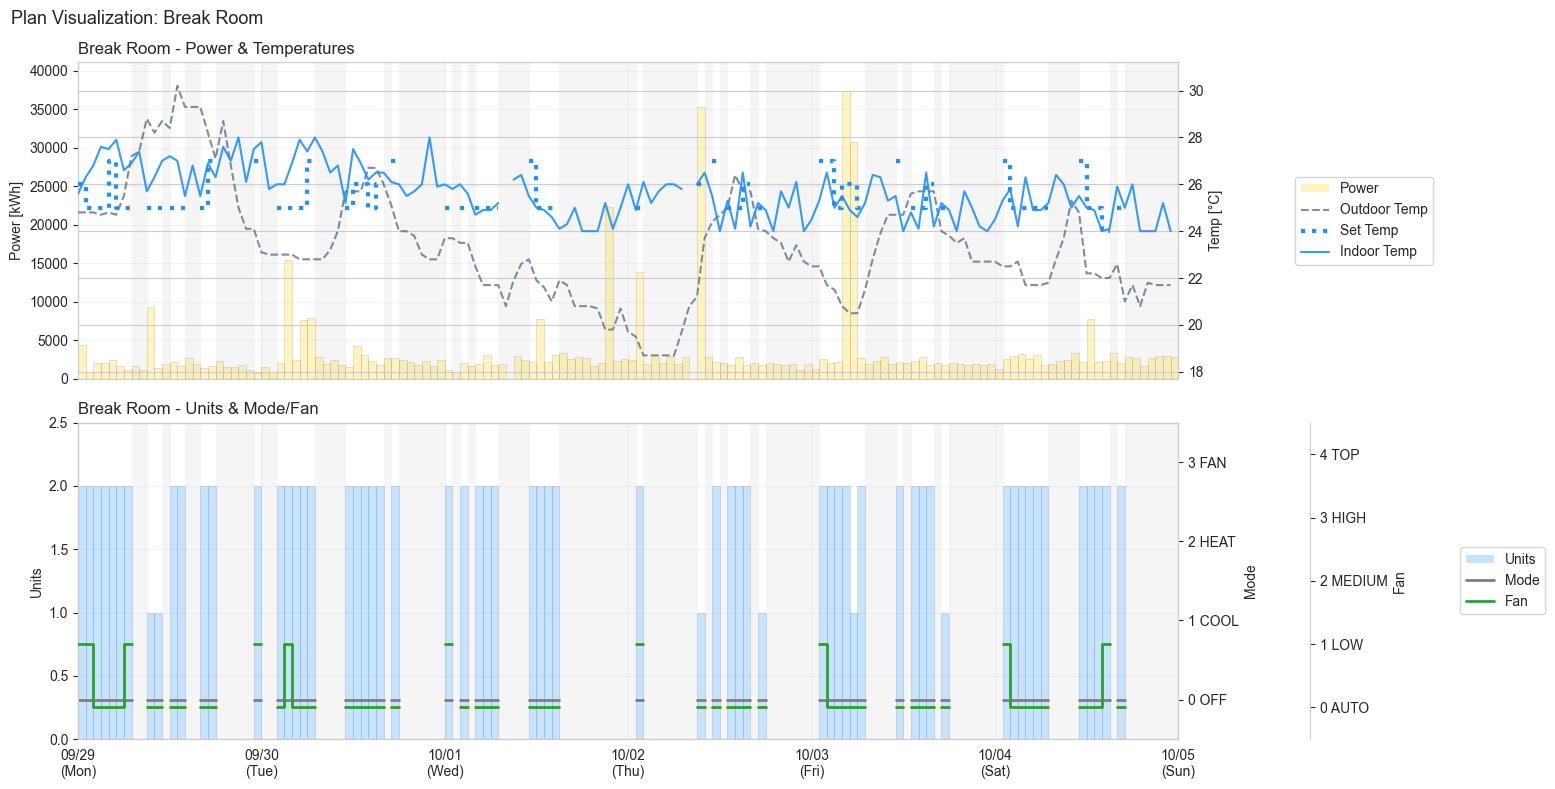

--- Plan Plot: Meeting Room ---


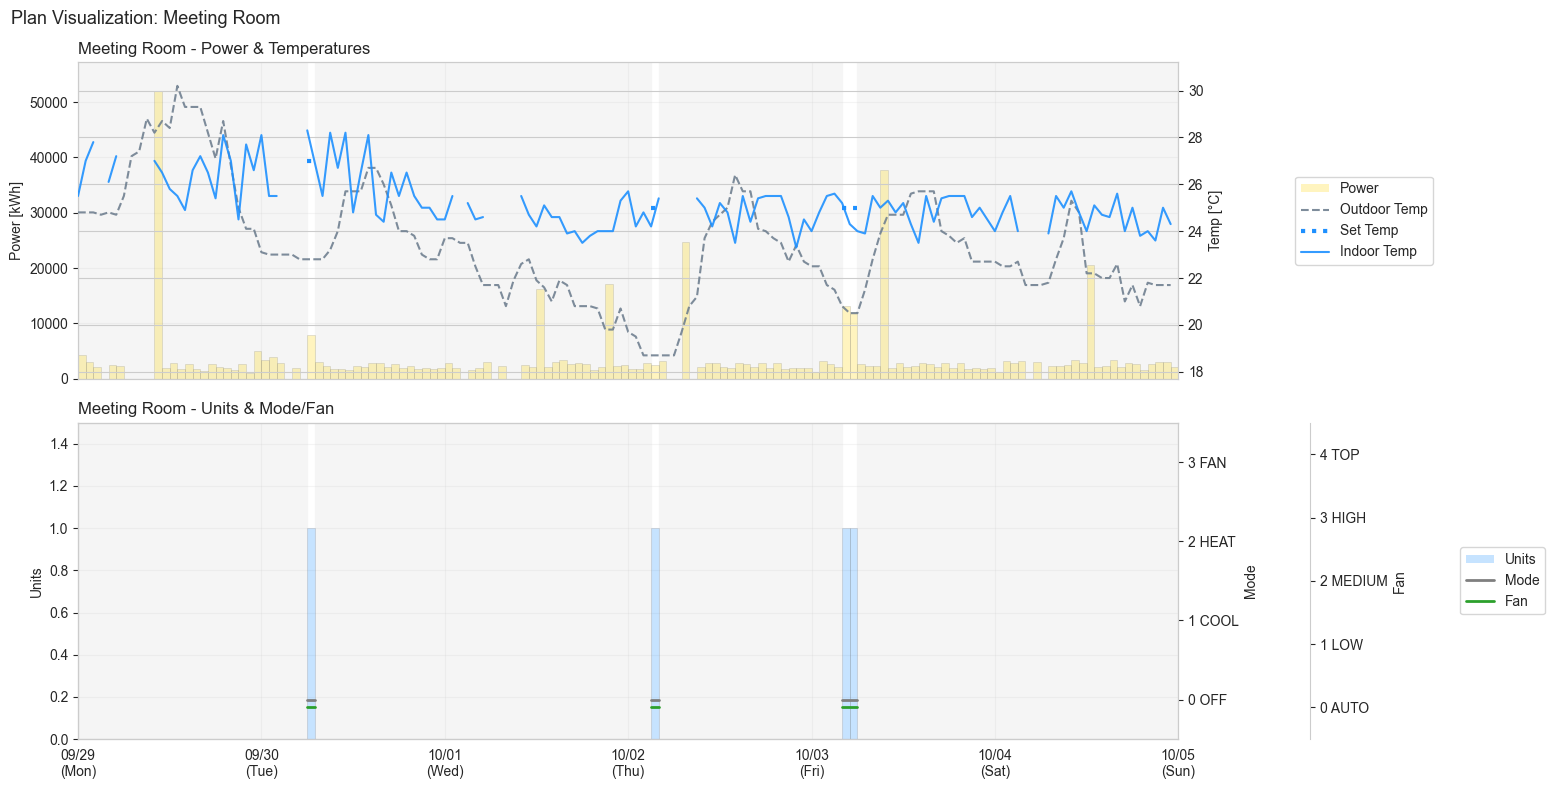

In [8]:
# 計画CSVの読み込みと一括可視化
PLAN_CSV = project_root / 'data/04_PlanningData/Clea/optimized_results_20250929_20251004.csv'
assert PLAN_CSV.exists(), f'計画CSVが見つかりません: {PLAN_CSV}'
plan_df = pd.read_csv(PLAN_CSV)
if 'datetime' in plan_df.columns:
    plan_df['datetime'] = pd.to_datetime(plan_df['datetime'])
elif 'Datetime' in plan_df.columns:
    plan_df['datetime'] = pd.to_datetime(plan_df['Datetime'])
else:
    raise ValueError('datetime列が見つかりません')

zones_plan = infer_plan_zones(plan_df.columns.tolist())
print(f'✅ 計画読込: shape={plan_df.shape}, zones={zones_plan}')

START_PLAN = ''  # 例: '2025-09-29'
END_PLAN   = ''  # 例: '2025-10-04'
for z in zones_plan:
    print(f'--- Plan Plot: {z} ---')
    plot_zone_plan_styled(plan_df, z, START_PLAN, END_PLAN)
